## Load the required Libraries

In [565]:
# Load required Libraries
import warnings
warnings.filterwarnings("ignore", message=".*use_inf_as_na option is deprecated.*", category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score

import pickle


## Load and Read Dataset

In [122]:
# Load & Read Dataset
df= pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [124]:
df = df.drop(columns='id',axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# **EDA**

In [125]:
features = df.columns
features

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [126]:
Numerical_columns = [feature for feature in features if df[feature].dtypes !='O']
Categorical_columns = [feature for feature in features if df[feature].dtypes =='O']


In [127]:

corr = df[Numerical_columns].corr().round(2)
corr


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.00,0.28,0.26,0.24,0.33,0.25
hypertension,0.28,1.00,0.11,0.17,0.17,0.13
heart_disease,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.24,0.17,0.16,1.00,0.18,0.13
bmi,0.33,0.17,0.04,0.18,1.00,0.04
stroke,0.25,0.13,0.13,0.13,0.04,1.00


<Axes: >

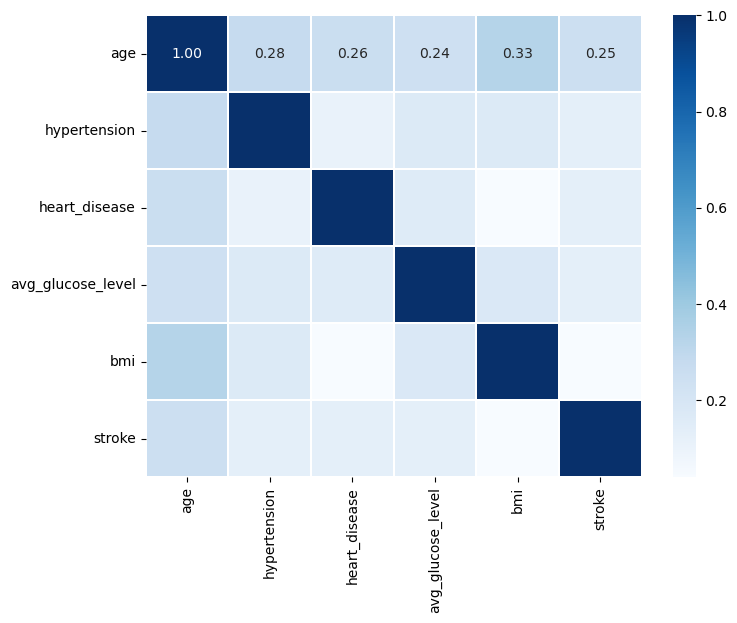

In [128]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt= '.2f',cmap= 'Blues',linewidths= 0.1)


In [129]:
df.stroke.unique()# CHECKING TARGET VARIABLE

array([1, 0], dtype=int64)

In [130]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

AN IMBALANCED DATASET 

<Axes: xlabel='stroke', ylabel='count'>

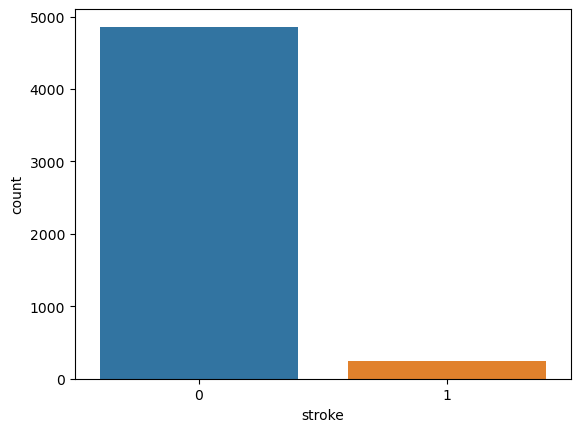

In [131]:
sns.countplot(x = df.stroke)

(0.0, 1.0, 0.0, 1.0)

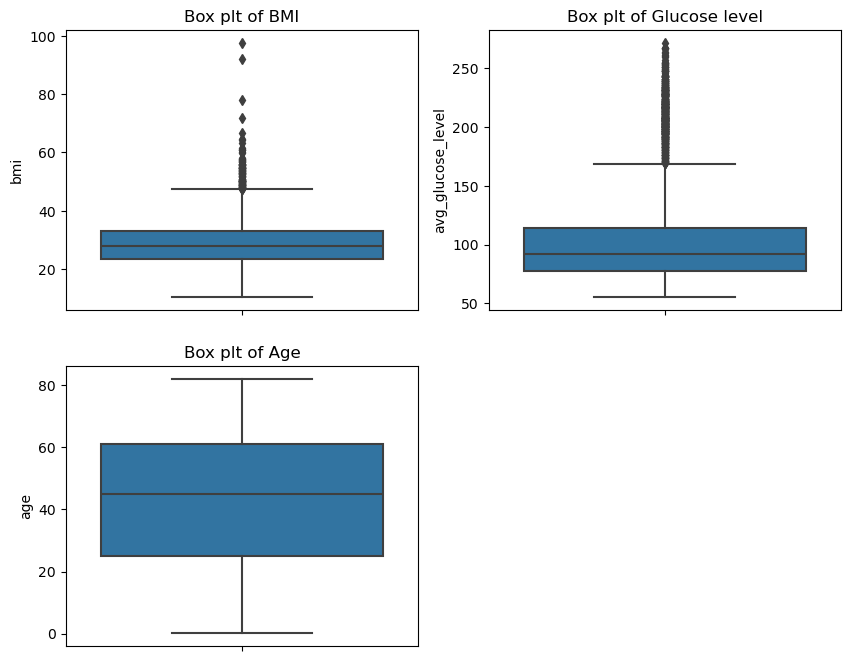

In [132]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.boxplot(y= df['bmi'], ax=ax1)
ax1.set_title('Box plt of BMI')
sns.boxplot(y= df['avg_glucose_level'], ax=ax2)
ax2.set_title('Box plt of Glucose level')
sns.boxplot(y=df['age'], ax=ax3)
ax3.set_title('Box plt of Age')

ax4.axis('off')

<Axes: xlabel='avg_glucose_level', ylabel='Count'>

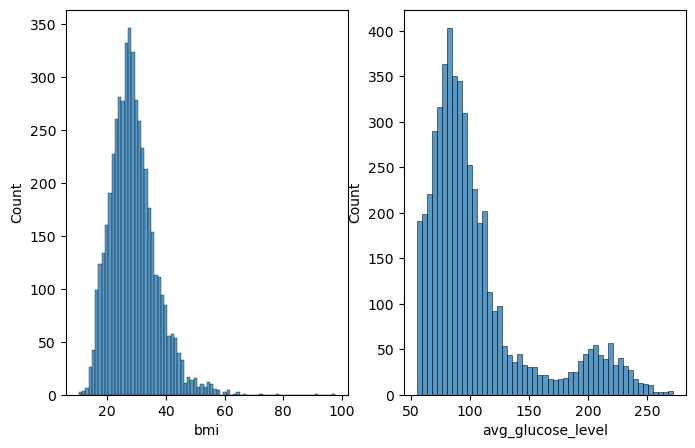

In [133]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
sns.histplot(x ='bmi', data= df, ax=ax1)
sns.histplot(x= 'avg_glucose_level', data= df, ax= ax2)


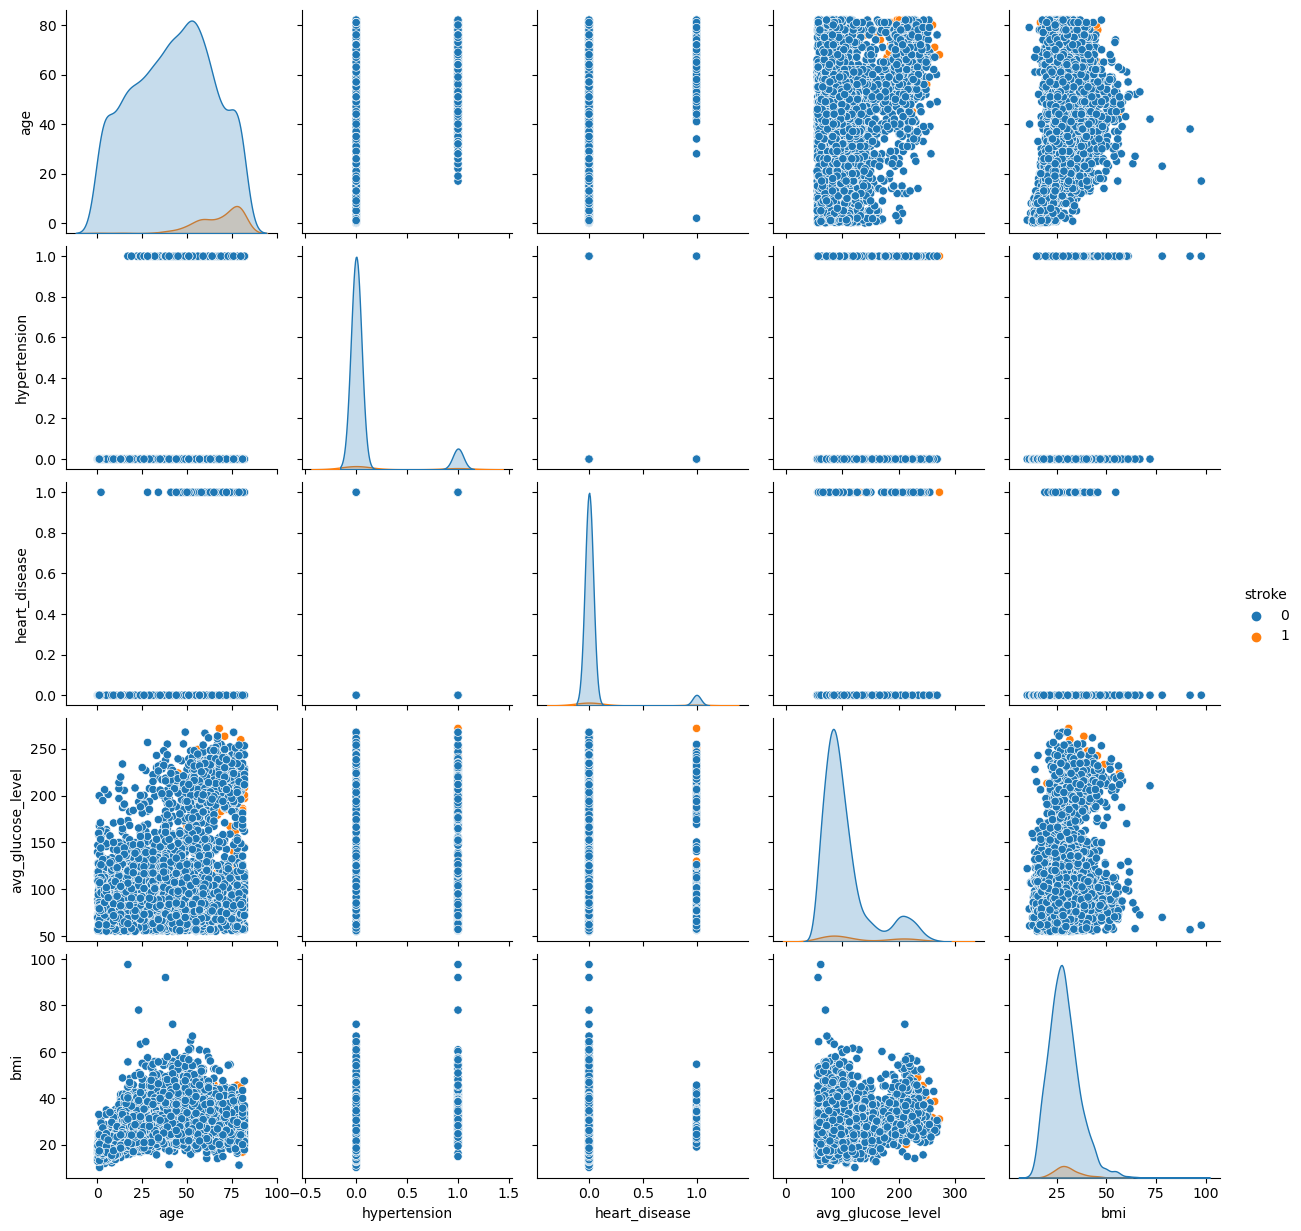

In [134]:
sns.pairplot(df[Numerical_columns], hue = 'stroke')

### CATEGORICAL FEATURES

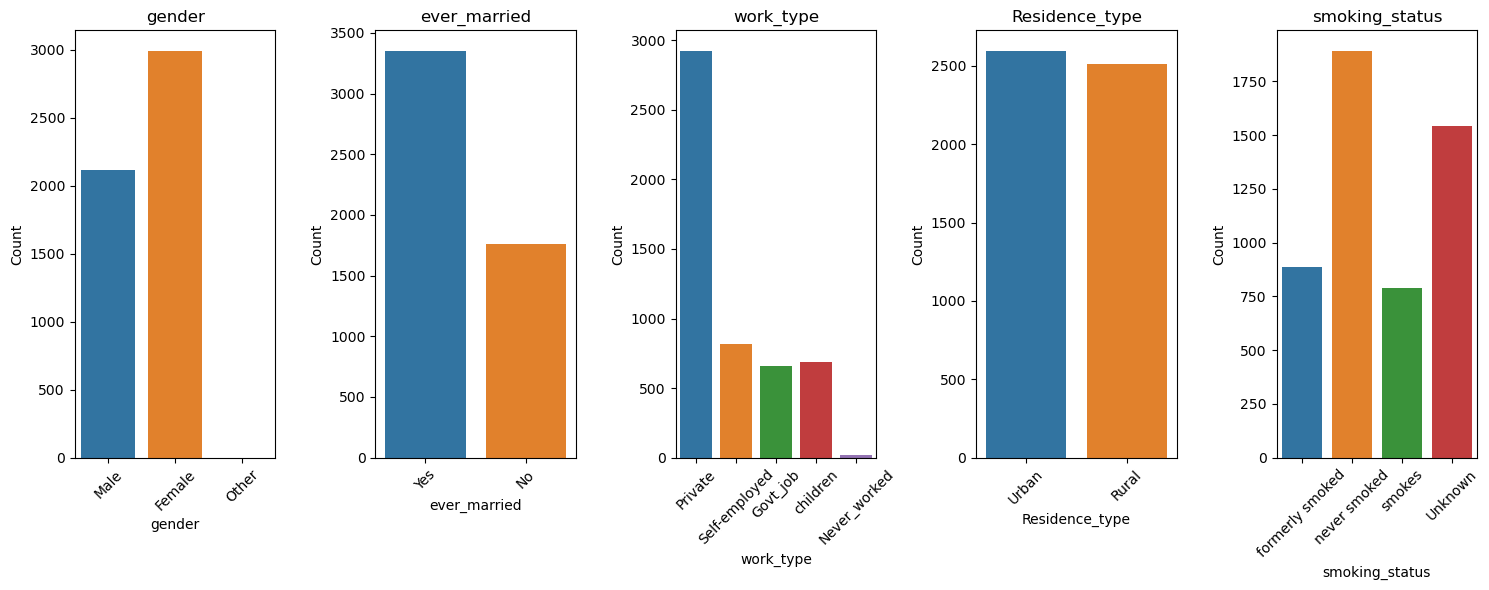

In [135]:
num_features = len(Categorical_columns)
fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 6))

for i, feature in enumerate(Categorical_columns):
    sns.countplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

# **PREPROCESSING**

## Handling Missing/NA values


In [136]:
# Check for Missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We have 201 null values in the column bmi, so we need do imputation technique 

In [137]:
#IMPUTE MISSING VALUE WITH MEAN 
bmi_mean = df['bmi'].mean()
df.bmi = df['bmi'].fillna(bmi_mean)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


## Duplicates

In [138]:
# CHECK FOR DUPLICATE
df.duplicated().sum()

0

No duplicates found

## Handling Outliers

In [139]:
# Handling Outliers
numerical_columns_excluding_binary_age = [col for col in Numerical_columns if col not in ['hypertension', 'heart_disease', 'stroke', 'age']]
print(numerical_columns_excluding_binary_age)
Q1 = df[numerical_columns_excluding_binary_age].quantile(0.25)
Q3 = df[numerical_columns_excluding_binary_age].quantile(0.75)
print(Q1)
print(Q3)
IQR = Q3 - Q1
print(IQR)


['avg_glucose_level', 'bmi']
avg_glucose_level    77.245
bmi                  23.800
Name: 0.25, dtype: float64
avg_glucose_level    114.09
bmi                   32.80
Name: 0.75, dtype: float64
avg_glucose_level    36.845
bmi                   9.000
dtype: float64


In [140]:
df = df[~((df[numerical_columns_excluding_binary_age] < (Q1 - 1.5 * IQR)) |(df[numerical_columns_excluding_binary_age] > (Q3 + 1.5 * IQR))).any(axis=1)].reset_index(drop=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
1,Male,74.0,1,1,Yes,Private,Rural,70.09,27.400000,never smoked,1
2,Female,69.0,0,0,No,Private,Urban,94.39,22.800000,never smoked,1
3,Female,59.0,0,0,Yes,Private,Rural,76.15,28.893237,Unknown,1
4,Female,78.0,0,0,Yes,Private,Urban,58.57,24.200000,Unknown,1


## Feature Engineering


In [141]:
# Define function to map BMI to categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Apply function to create new feature
df['bmi_category'] = df['bmi'].apply(categorize_bmi)

In [142]:
new_features = df.columns
new_features

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'bmi_category'],
      dtype='object')

## Feature Encoding

In [143]:
#Label Encoding 
Categorical_column = [feature for feature in new_features if df[feature].dtype =='O']
encoding = LabelEncoder()

for column in Categorical_column:
     df[column + '_encoded'] = encoding.fit_transform(df[column])
    
df.drop(columns=Categorical_column, inplace=True)

In [144]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,bmi_category_encoded
0,80.0,0,1,105.92,32.500000,1,1,1,2,0,2,1
1,74.0,1,1,70.09,27.400000,1,1,1,2,0,2,2
2,69.0,0,0,94.39,22.800000,1,0,0,2,1,2,0
3,59.0,0,0,76.15,28.893237,1,0,1,2,0,0,2
4,78.0,0,0,58.57,24.200000,1,0,1,2,1,0,0


In [145]:
# Add the 'stroke' column to the end
stroke_column = df.pop('stroke')
df['stroke'] = stroke_column


In [146]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,bmi_category_encoded,stroke
0,80.0,0,1,105.92,32.500000,1,1,2,0,2,1,1
1,74.0,1,1,70.09,27.400000,1,1,2,0,2,2,1
2,69.0,0,0,94.39,22.800000,0,0,2,1,2,0,1
3,59.0,0,0,76.15,28.893237,0,1,2,0,0,2,1
4,78.0,0,0,58.57,24.200000,0,1,2,1,0,0,1


In [147]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_encoded,ever_married_encoded,work_type_encoded,Residence_type_encoded,smoking_status_encoded,bmi_category_encoded,stroke
count,4391.000000,4391.000000,4391.000000,4391.000000,4391.000000,4391.000000,4391.000000,4391.000000,4391.000000,4391.000000,4391.000000,4391.000000
mean,40.896406,0.074243,0.039171,91.477067,27.811399,0.410385,0.622865,2.201093,0.507857,1.345479,1.199954,0.037577
std,22.544349,0.262195,0.194024,22.662442,6.562244,0.492422,0.484724,1.110053,0.499995,1.085093,0.922565,0.190192
min,0.080000,0.000000,0.000000,55.120000,11.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,75.075000,23.200000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,42.000000,0.000000,0.000000,88.040000,27.600000,0.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000
75%,58.000000,0.000000,0.000000,104.020000,31.900000,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000,0.000000
max,82.000000,1.000000,1.000000,168.680000,46.200000,2.000000,1.000000,4.000000,1.000000,3.000000,3.000000,1.000000


## Splitting Data Dependent and Independent Variables

In [148]:
#Independent and dependent columns
X = df.drop(columns='stroke')
y = df['stroke']

## Handling Imbalance Data

In [149]:
# TO OVERCOME IMBALANCED DATASET
from imblearn.over_sampling import SMOTE

smote= SMOTE()
x1,y1 =smote.fit_resample(X,y)
print(x1.shape)
print(y1.shape)
y1.value_counts()
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y1)))

(8452, 11)
(8452,)
The number of classes before fit Counter({0: 4226, 1: 165})
The number of classes after fit Counter({1: 4226, 0: 4226})


## Normalization

In [150]:
standard_scaler =StandardScaler()
X_scaled =standard_scaler.fit_transform(x1)

# **MODEL BUILDING**

In [152]:
#Split the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y1,train_size=0.8, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6761, 11)
(1691, 11)
(6761,)
(1691,)


In [153]:
#Build model
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [154]:
y_pred = lr.predict(X_test)
accuracy =accuracy_score(y_test,y_pred)
print(accuracy)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.8202247191011236
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       833
           1       0.83      0.82      0.82       858

    accuracy                           0.82      1691
   macro avg       0.82      0.82      0.82      1691
weighted avg       0.82      0.82      0.82      1691

[[684 149]
 [155 703]]


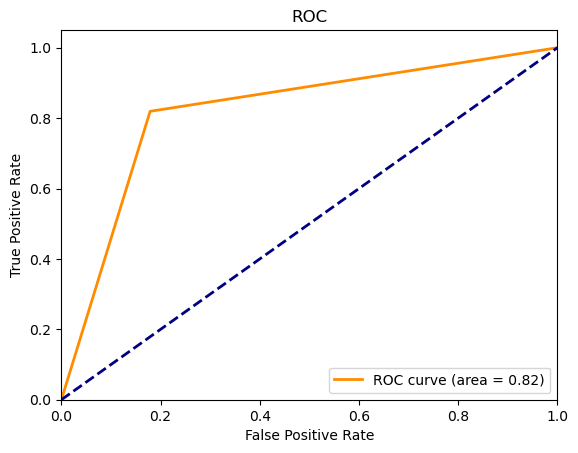

In [155]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [532]:
Dt= DecisionTreeClassifier(max_features='sqrt')
Dt.fit(X_train, y_train)


DecisionTreeClassifier(max_features='sqrt')

In [533]:
y_pred = Dt.predict(X_test)
accuracy =accuracy_score(y_test,y_pred)
print(f'Test Accuracy : ',accuracy)

print(f'Classification Report : ' , '\n',classification_report(y_test,y_pred,zero_division = 1))
print(f'Confusion Matrix : ' , '\n',confusion_matrix(y_test,y_pred))

Test Accuracy :  0.9302188054405677
Classification Report :  
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       833
           1       0.92      0.94      0.93       858

    accuracy                           0.93      1691
   macro avg       0.93      0.93      0.93      1691
weighted avg       0.93      0.93      0.93      1691

Confusion Matrix :  
 [[766  67]
 [ 51 807]]


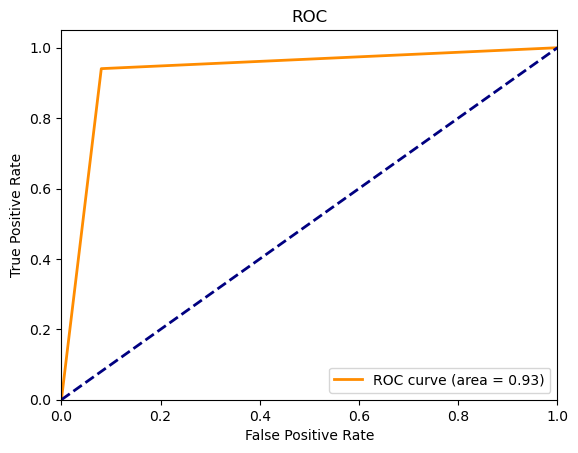

In [534]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [552]:
rf =RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [553]:
y_pred= rf.predict(X_test)
accuracy =accuracy_score(y_test,y_pred)
print(f'Test Accuracy : ',accuracy)
print(f'Classification Report : ' , '\n',classification_report(y_test,y_pred,zero_division = 1))
print(f'Confusion Matrix : ' , '\n',confusion_matrix(y_test,y_pred))

Test Accuracy :  0.9603784742755765
Classification Report :  
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       833
           1       0.95      0.97      0.96       858

    accuracy                           0.96      1691
   macro avg       0.96      0.96      0.96      1691
weighted avg       0.96      0.96      0.96      1691

Confusion Matrix :  
 [[791  42]
 [ 25 833]]


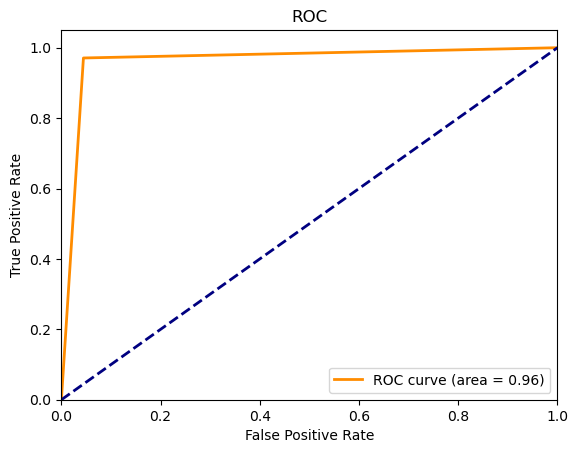

In [379]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [380]:
svm = SVC()
svm.fit(X_train,y_train)
svm.score(X_test,y_test)

0.8971023063276168

In [191]:
y_pred = svm.predict(X_test)
accuracy =accuracy_score(y_test,y_pred)
print(f'Test Accuracy : ',accuracy)
print(f'Classification Report : ' , '\n',classification_report(y_test,y_pred,zero_division = 1))
print(f'Confusion Matrix : ' , '\n',confusion_matrix(y_test,y_pred))

Test Accuracy :  0.8971023063276168
Classification Report :  
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       833
           1       0.88      0.92      0.90       858

    accuracy                           0.90      1691
   macro avg       0.90      0.90      0.90      1691
weighted avg       0.90      0.90      0.90      1691

Confusion Matrix :  
 [[726 107]
 [ 67 791]]


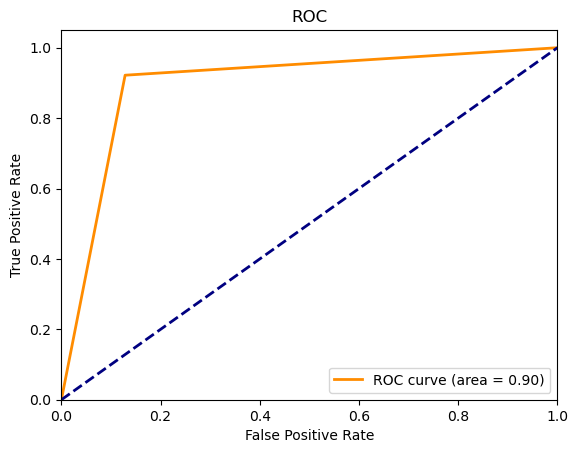

In [192]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [193]:
naive_bais = GaussianNB()
naive_bais.fit(X_train, y_train)

GaussianNB()

In [194]:
y_pred = naive_bais.predict(X_test)
accuracy =accuracy_score(y_test,y_pred)
print(f'Test Accuracy : ',accuracy)
print(f'Classification Report : ' , '\n',classification_report(y_test,y_pred,zero_division = 1))
print(f'Confusion Matrix : ' , '\n',confusion_matrix(y_test,y_pred))

Test Accuracy :  0.8255470136014192
Classification Report :  
               precision    recall  f1-score   support

           0       0.88      0.74      0.81       833
           1       0.78      0.90      0.84       858

    accuracy                           0.83      1691
   macro avg       0.83      0.82      0.82      1691
weighted avg       0.83      0.83      0.82      1691

Confusion Matrix :  
 [[620 213]
 [ 82 776]]


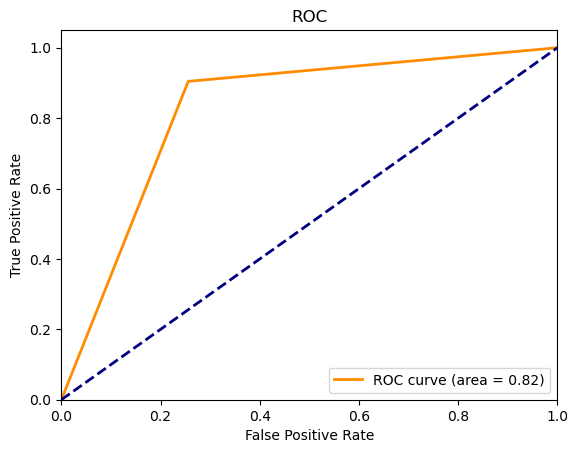

In [195]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [203]:
log_reg_model = LogisticRegression()
Decision_tree_model = DecisionTreeClassifier()
Random_forest_model = RandomForestClassifier()
naive_bais_model =GaussianNB()
svm_model = SVC()
KNN_model =KNeighborsClassifier()
Grad_Boosting = GradientBoostingClassifier()


In [204]:
model_list = [log_reg_model, Decision_tree_model, Random_forest_model,naive_bais_model, svm_model, KNN_model, Grad_Boosting]
accuracy_list1 =[]
accuracy_list2 =[]
model_name = []
for model in model_list:
    model.fit(X_train,y_train)
    X_pred = model.predict(X_train)
    Train_Accuracy = accuracy_score(y_train, X_pred)
    y_pred = model.predict(X_test)
    Test_Accuracy = accuracy_score(y_test, y_pred)
    
    accuracy_list1.append(Train_Accuracy)
    accuracy_list2.append(Test_Accuracy)
    model_name.append(model.__class__.__name__)



In [205]:
model_df= pd.DataFrame({'Model':model_name, 'Train_Accuracy':accuracy_list1, 'Test_Accuracy':accuracy_list2})
model_df

,Model,Train_Accuracy,Test_Accuracy
0,LogisticRegression,0.806981,0.820225
1,DecisionTreeClassifier,1.000000,0.917800
2,RandomForestClassifier,1.000000,0.963335
3,GaussianNB,0.800177,0.825547
4,SVC,0.889809,0.897102
5,KNeighborsClassifier,0.923976,0.911886
6,GradientBoostingClassifier,0.910960,0.908930


# Model Validation

In [622]:
model_list = [log_reg_model, Decision_tree_model, Random_forest_model,naive_bais_model, svm_model, KNN_model,Grad_Boosting]

CV = 5
accuracy_list =[]
model_name = []
for model in model_list:
    accuracy_cv = cross_val_score(model,X_scaled,y1,scoring= 'accuracy',cv=CV)
    accuracy = accuracy_cv.mean()
    accuracy_list.append(accuracy)
    model_name.append(model.__class__.__name__)
   


In [207]:
model_df_cv= pd.DataFrame({'Model':model_name, 'Accuracy':accuracy_list})
model_df_cv

,Model,Accuracy
0,LogisticRegression,0.809158
1,DecisionTreeClassifier,0.926646
2,RandomForestClassifier,0.956699
3,GaussianNB,0.804900
4,SVC,0.880624
5,KNeighborsClassifier,0.897068
6,GradientBoostingClassifier,0.897542


In [542]:
#Random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [603]:
param_random = {'ccp_alpha': [0.1,1e-2, 1e-4,1e-6],
               'n_estimators':[int(x) for x in np.linspace(start =100,stop =1000,num =10)],
               'bootstrap':[True, False],
               'max_features':['sqrt','log2','auto'],
               'min_samples_leaf':[1,2,3,5,6,7],
               'min_samples_split':[2,4,6,8,10],
               'max_depth': [int(x) for x in np.linspace(10, 1000,10)],
               'criterion':['gini', 'entropy', 'log_loss']
               
               }
random = RandomizedSearchCV(estimator=rf, param_distributions=param_random, n_iter=100, random_state=100,cv=3, verbose =2, n_jobs=-1 )

random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.1, 0.01, 0.0001, 1e-06],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['sqrt', 'log2',
                                                         'auto'],
                                        'min_samples_leaf': [1, 2, 3, 5, 6, 7],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=100, verbose=2)

In [604]:
random.best_params_

{'n_estimators': 600,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 560,
 'criterion': 'log_loss',
 'ccp_alpha': 0.0001,
 'bootstrap': False}

In [609]:
best_random_cv=random.best_estimator_
y_pred = best_random_cv.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))


[[805  28]
 [ 28 830]]
Accuracy Score 0.9668835008870491
Classification report:               precision    recall  f1-score   support

           0       0.97      0.97      0.97       833
           1       0.97      0.97      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691



In [606]:
param_grid = {'ccp_alpha':[random.best_params_['ccp_alpha']],
               'n_estimators': [random.best_params_['n_estimators']-200, random.best_params_['n_estimators']-100,random.best_params_['n_estimators'],
                                random.best_params_['n_estimators']+100, random.best_params_['n_estimators']+200 ],
               'bootstrap':[random.best_params_['bootstrap']],
               'max_features':[random.best_params_['max_features']],
               'min_samples_leaf':[random.best_params_['min_samples_leaf'],random.best_params_['min_samples_leaf']+1],
               'min_samples_split':[random.best_params_['min_samples_split']-2,random.best_params_['min_samples_split']-1,random.best_params_['min_samples_split'],
                                    random.best_params_['min_samples_split']+1, random.best_params_['min_samples_split']+2],
               'max_depth': [random.best_params_['max_depth']],
               'criterion':[random.best_params_['criterion']]
               
    
}
print(param_grid)

{'ccp_alpha': [0.0001], 'n_estimators': [400, 500, 600, 700, 800], 'bootstrap': [False], 'max_features': ['log2'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 3, 4, 5, 6], 'max_depth': [560], 'criterion': ['log_loss']}


In [607]:
grid = GridSearchCV(estimator=rf, param_grid =param_grid, cv=10,n_jobs=-1, verbose =2)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'ccp_alpha': [0.0001],
                         'criterion': ['log_loss'], 'max_depth': [560],
                         'max_features': ['log2'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [400, 500, 600, 700, 800]},
             verbose=2)

In [608]:
grid.best_params_

{'bootstrap': False,
 'ccp_alpha': 0.0001,
 'criterion': 'log_loss',
 'max_depth': 560,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [610]:
best_grid_cv=grid.best_estimator_
y_pred = best_grid_cv.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[804  29]
 [ 24 834]]
Accuracy Score 0.9686575990538143
Classification report:               precision    recall  f1-score   support

           0       0.97      0.97      0.97       833
           1       0.97      0.97      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691



In [620]:
##########################################
y_pred_train = best_grid_cv.predict(X_train)
y_pred_test = best_grid_cv.predict(X_test)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_confusion_matrix = confusion_matrix(y_train, y_pred_train)

# Calculate accuracy and other metrics for test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_confusion_matrix = confusion_matrix(y_test, y_pred_test)

# Step 2: Compare Training and Test Performance
print("Training Accuracy: {:.4f}".format(train_accuracy))
print("Training Confusion Matrix:")
print(train_confusion_matrix)
print()
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Test Confusion Matrix:")
print(test_confusion_matrix)
print()



Training Accuracy: 1.0000
Training Confusion Matrix:
[[3393    0]
 [   0 3368]]

Test Accuracy: 0.9687
Test Confusion Matrix:
[[804  29]
 [ 24 834]]



In [621]:
CV = 5
accuracy_cv = cross_val_score(best_grid_cv, X_train, y_train, scoring='accuracy', cv=CV)
print("Cross-Validated Accuracy: {:.4f}".format(accuracy_cv.mean()))

Cross-Validated Accuracy: 0.9550


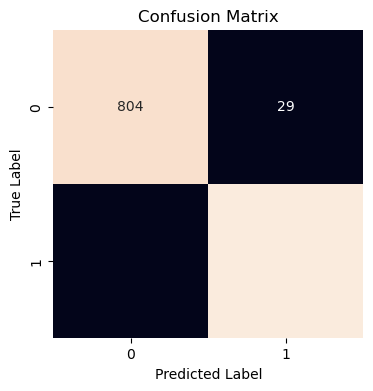

In [617]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False
            )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [537]:
with open('rf_model_pickle.pkl','wb') as file:
    pickle.dump(rf,file)